In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set(style="whitegrid")
plt.rcParams.update({"figure.dpi": 110})



In [2]:
# ============================================================
# 0. Path & Load
# ============================================================
BASE_DIR = Path.cwd().resolve()
DATA_DIR = BASE_DIR.parents[1] / "data" / "processed"

MONTHLY_PATH = DATA_DIR / "train_monthly_step1prep.csv"

print("Loading:", MONTHLY_PATH)
df = pd.read_csv(MONTHLY_PATH)

# Ensure sorting
df = df.sort_values(["item_id", "year", "month"]).reset_index(drop=True)



Loading: /data/ephemeral/home/data/processed/train_monthly_step1prep.csv


Sample items: ['ZXERAXWP', 'AHMDUILJ', 'QJQJSWFU', 'WPQXWHYO', 'OXKURKXR', 'OKMBFVKS', 'OJIFIHMZ', 'NZKBIBNU', 'XIFHSOWQ', 'MBSBZBXA']


/tmp/ipykernel_351604/2107798666.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub["month"], rotation=45)


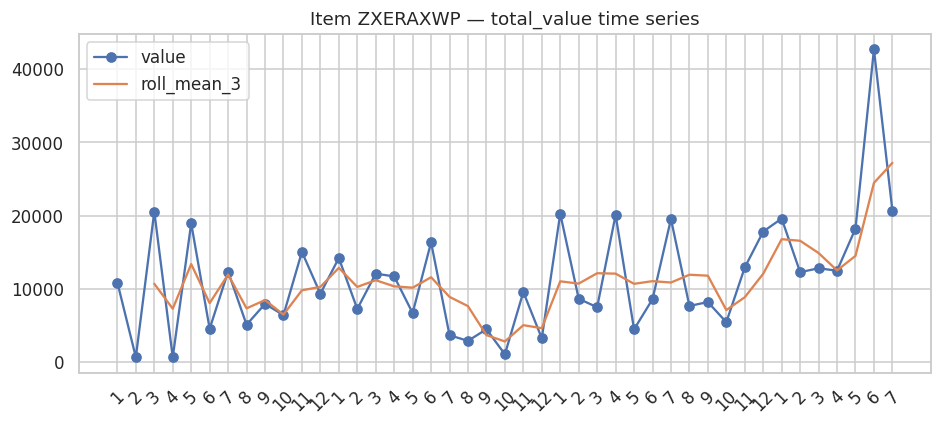

/tmp/ipykernel_351604/2107798666.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub["month"], rotation=45)


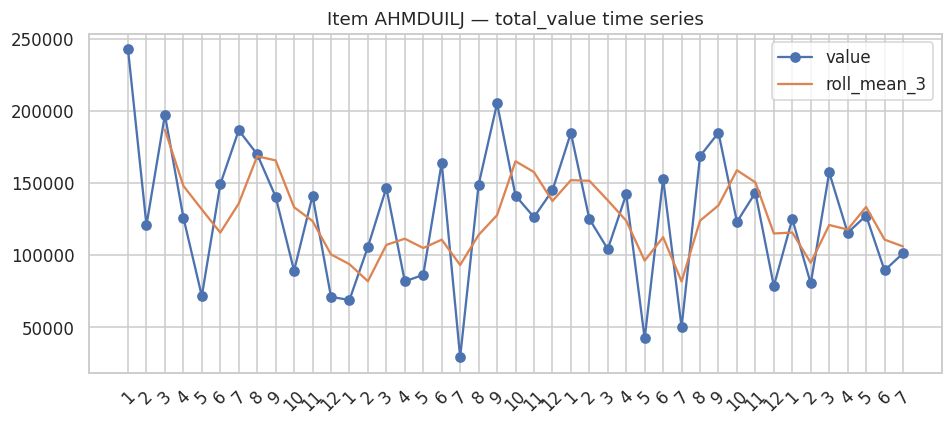

/tmp/ipykernel_351604/2107798666.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub["month"], rotation=45)


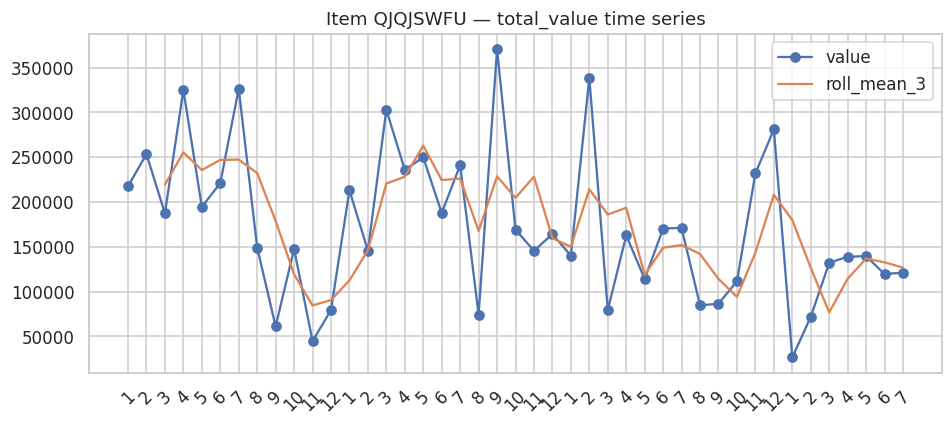

/tmp/ipykernel_351604/2107798666.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub["month"], rotation=45)


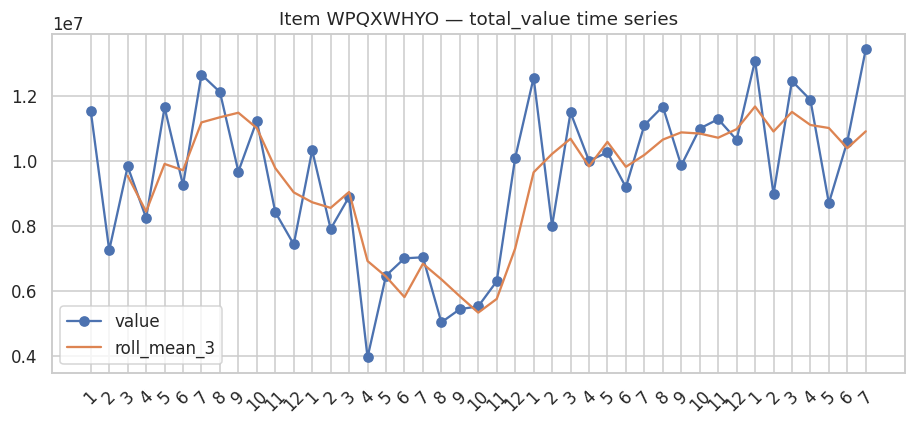

/tmp/ipykernel_351604/2107798666.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub["month"], rotation=45)


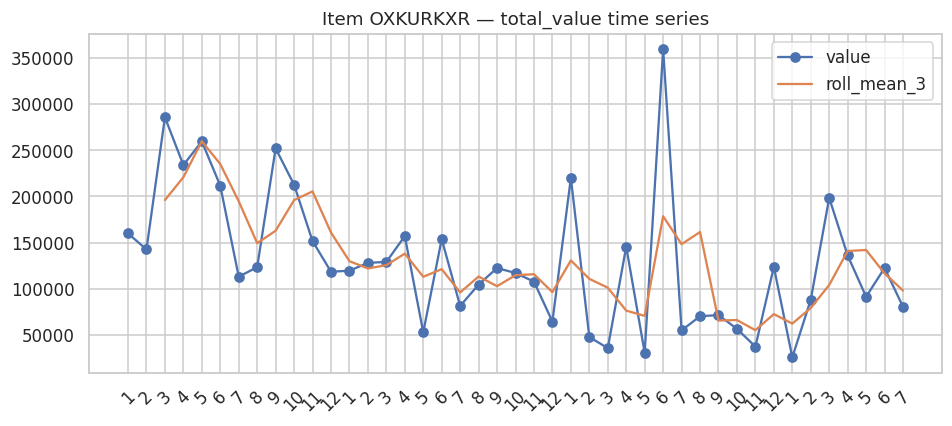

/tmp/ipykernel_351604/2107798666.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub["month"], rotation=45)


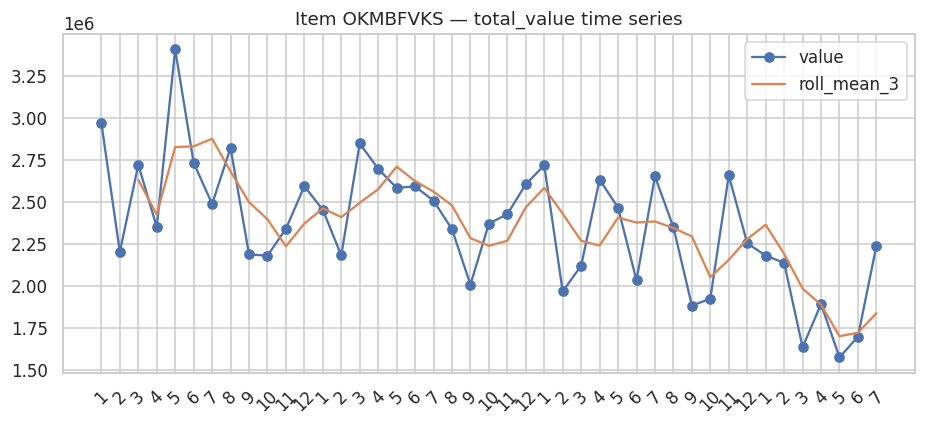

/tmp/ipykernel_351604/2107798666.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub["month"], rotation=45)


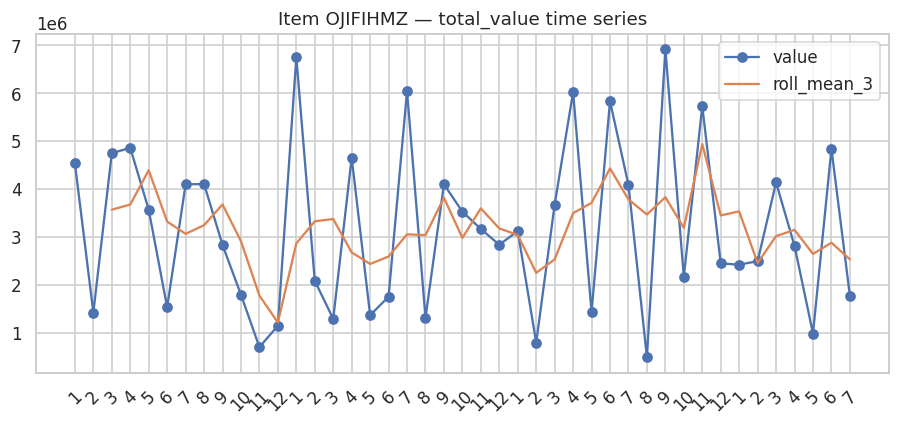

/tmp/ipykernel_351604/2107798666.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub["month"], rotation=45)


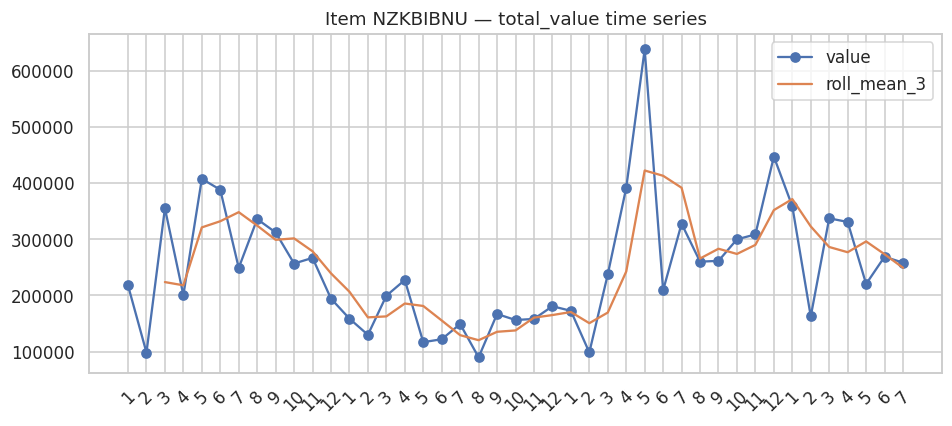

/tmp/ipykernel_351604/2107798666.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub["month"], rotation=45)


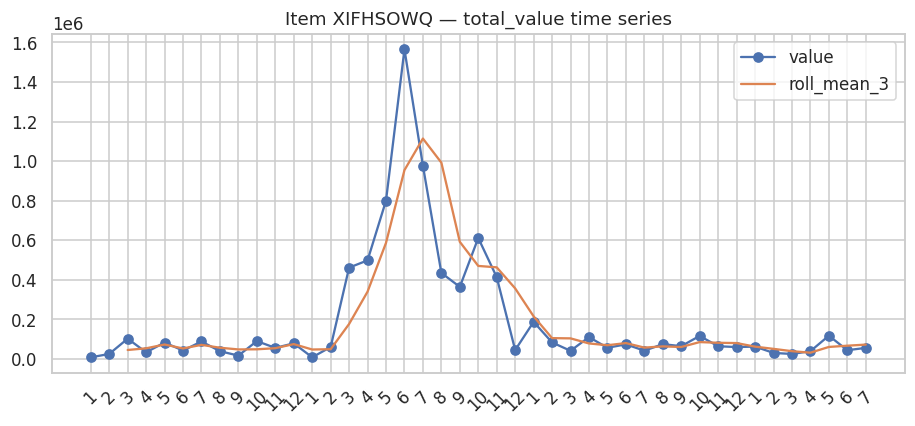

/tmp/ipykernel_351604/2107798666.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub["month"], rotation=45)


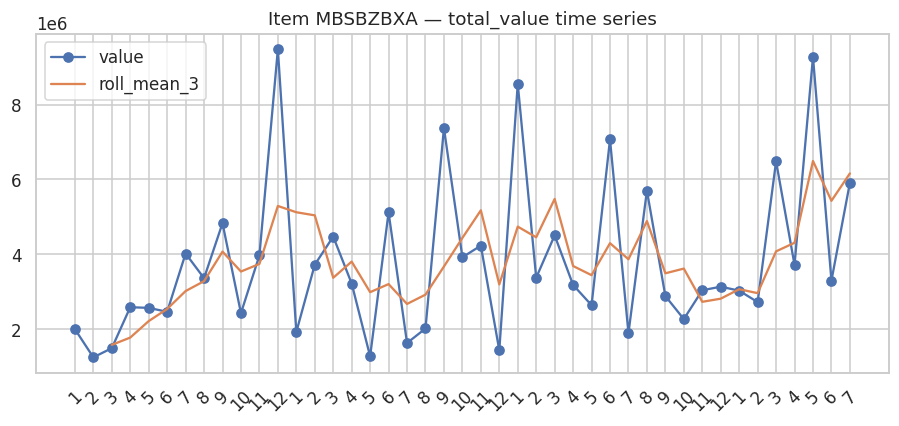

In [3]:

# ============================================================
# 1. Item-level Time Series Stability EDA
# ============================================================
def plot_item_timeseries(df, item_list, col="total_value"):
    for item in item_list:
        sub = df[df["item_id"] == item]
        if len(sub) == 0:
            continue

        fig, ax = plt.subplots(figsize=(10, 4))
        ax.plot(sub["year"].astype(str) + "-" + sub["month"].astype(str),
                sub[col], marker="o", label="value")

        if "roll_mean_3" in df.columns:
            ax.plot(sub["year"].astype(str) + "-" + sub["month"].astype(str),
                    sub["roll_mean_3"], label="roll_mean_3")

        ax.set_title(f"Item {item} — {col} time series")
        ax.set_xticklabels(sub["month"], rotation=45)
        ax.legend()
        plt.show()

# 샘플 10개만
sample_items = df["item_id"].value_counts().head(10).index.tolist()
print("Sample items:", sample_items)

plot_item_timeseries(df, sample_items, col="total_value")



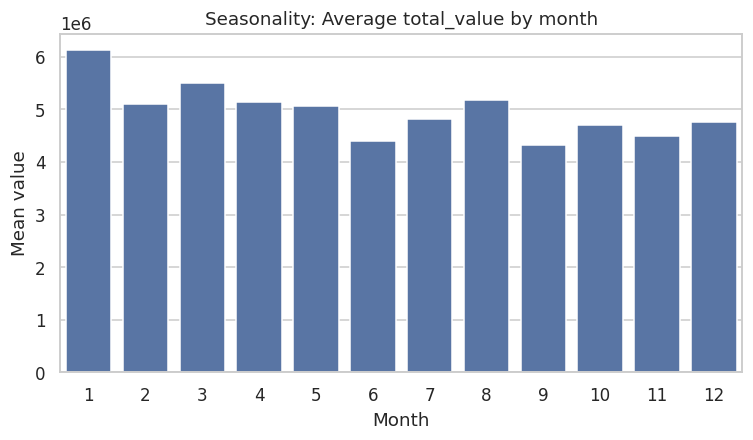

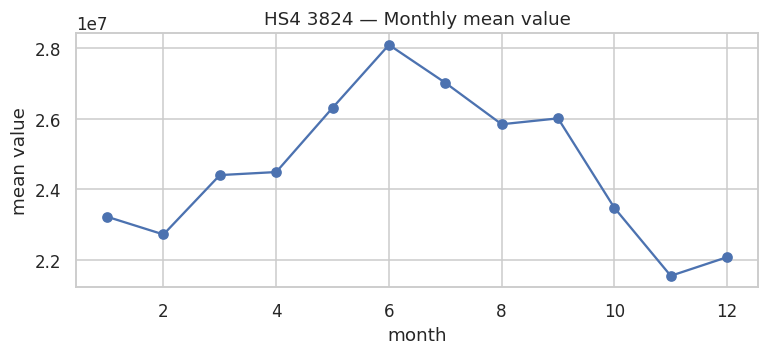

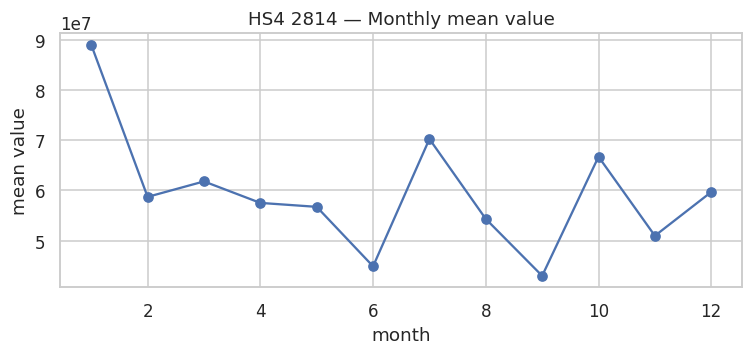

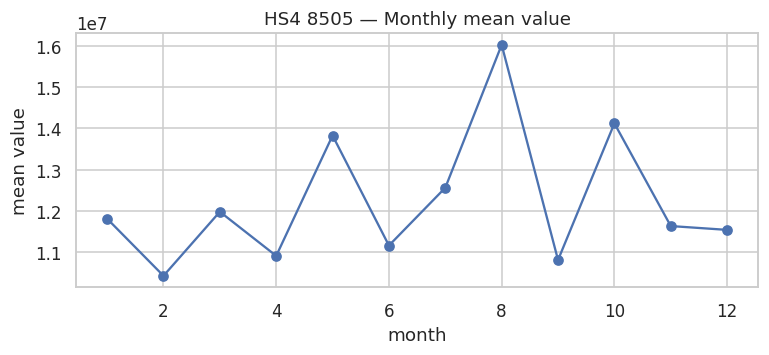

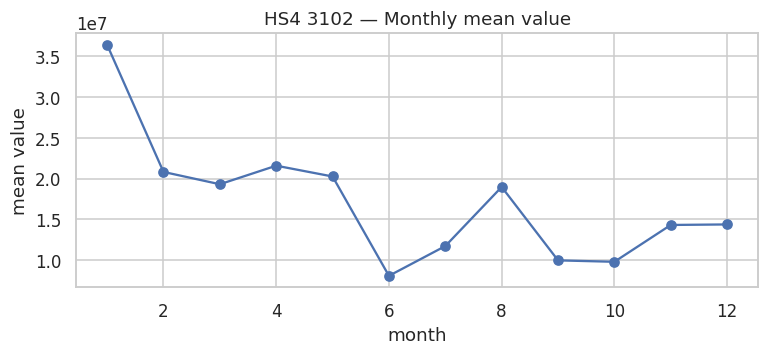

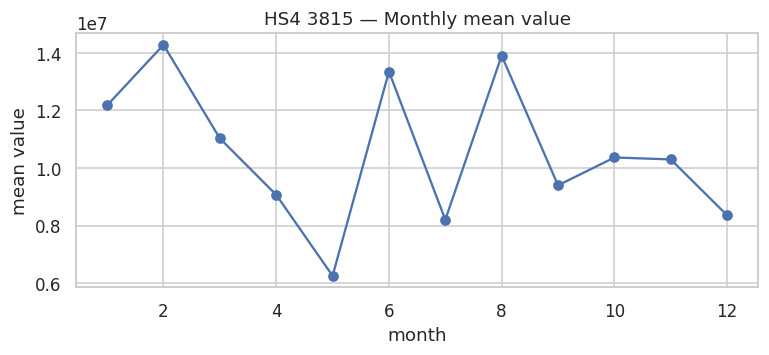

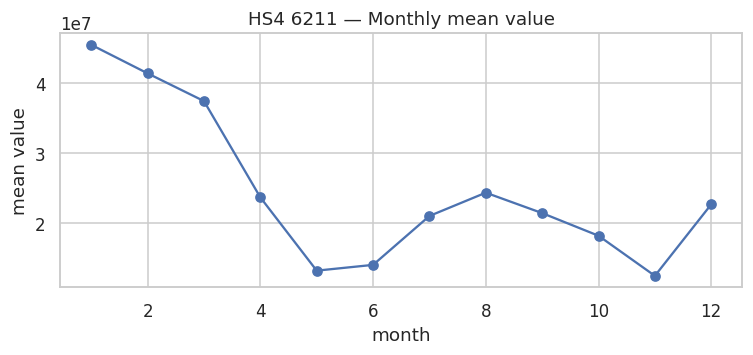

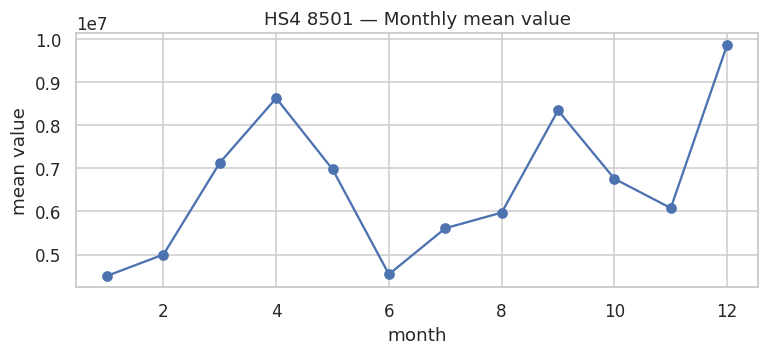

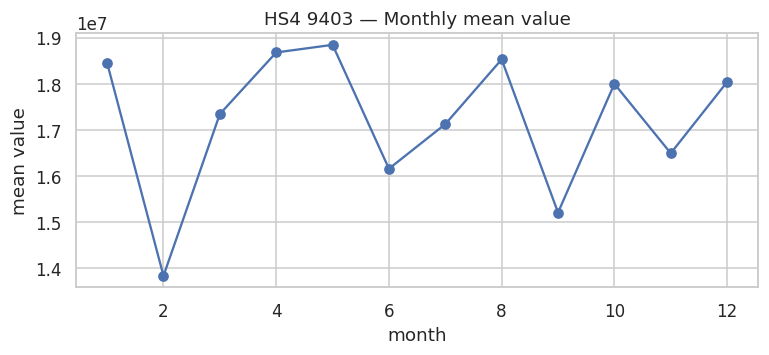

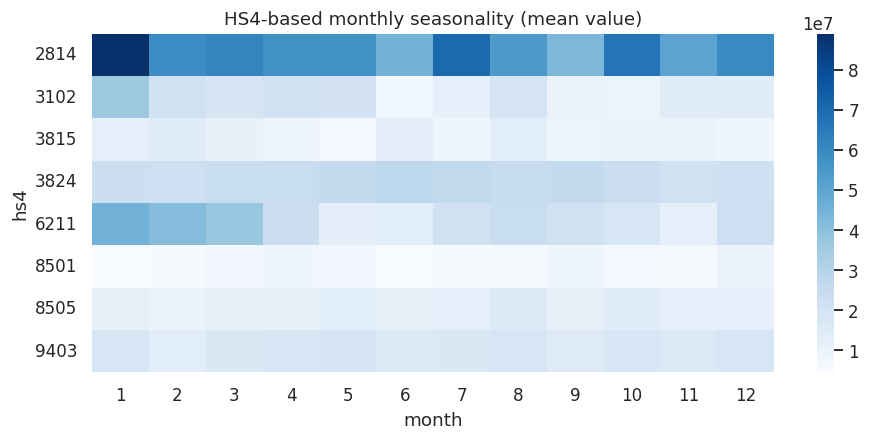

In [13]:
# ============================================================
# 2. Seasonality EDA (item-level & HS-level)
# ============================================================

# 2-1. Monthly average across all items
month_mean = df.groupby("month")["total_value"].mean()

plt.figure(figsize=(8,4))
sns.barplot(x=month_mean.index, y=month_mean.values)
plt.title("Seasonality: Average total_value by month")
plt.xlabel("Month")
plt.ylabel("Mean value")
plt.show()

# 2-2. HS4-level monthly pattern
hs4_top = df.groupby("hs4")["total_value"].sum().sort_values(ascending=False).head(8).index

for h in hs4_top:
    sub = df[df["hs4"] == h].groupby("month")["total_value"].mean()
    plt.figure(figsize=(8,3))
    plt.plot(sub.index, sub.values, marker="o")
    plt.title(f"HS4 {h} — Monthly mean value")
    plt.xlabel("month")
    plt.ylabel("mean value")
    plt.show()

# Heatmap of HS4 vs month
pivot_hs4 = df[df["hs4"].isin(hs4_top)].pivot_table(
    index="hs4", columns="month", values="total_value", aggfunc="mean"
)

plt.figure(figsize=(10,4))
sns.heatmap(pivot_hs4, annot=False, cmap="Blues")
plt.title("HS4-based monthly seasonality (mean value)")
plt.show()




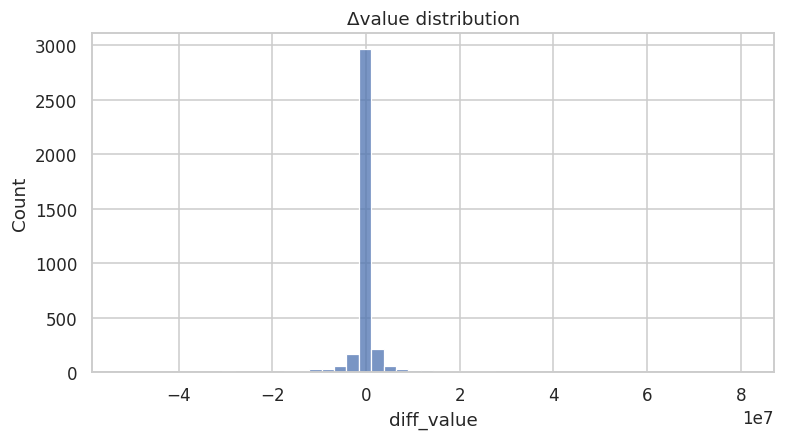

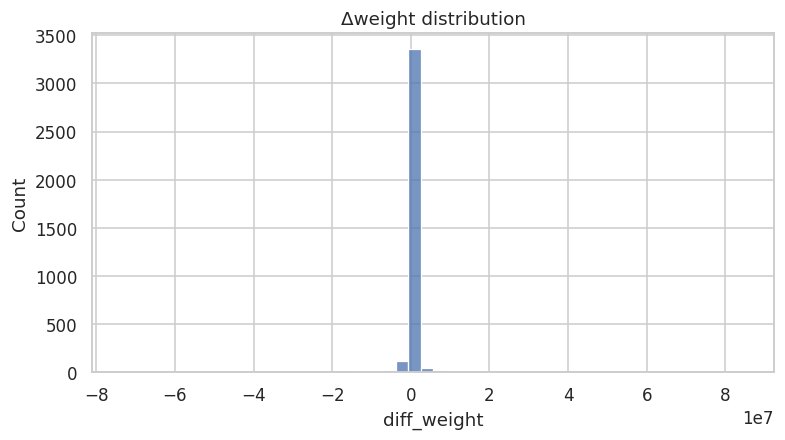

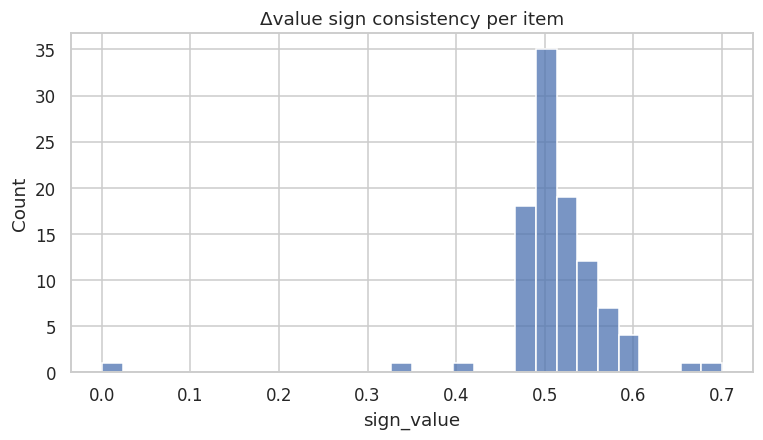

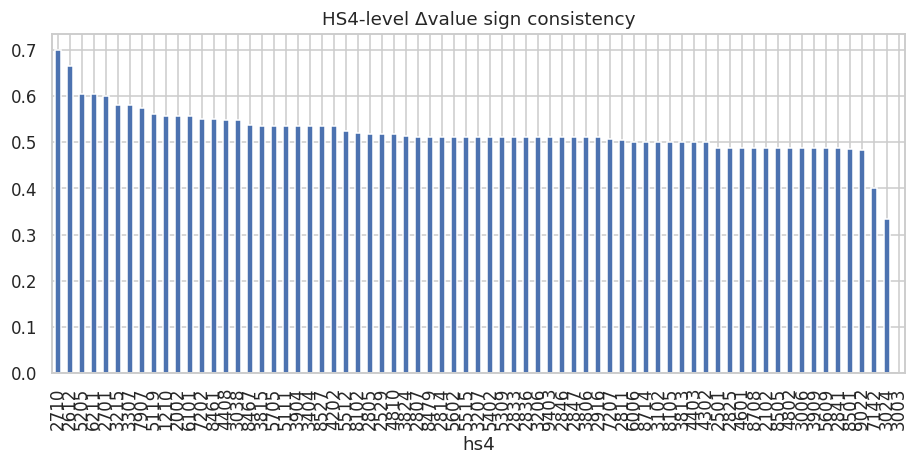

In [15]:

# ============================================================
# 3. Δvalue / Δweight EDA
# ============================================================

plt.figure(figsize=(8,4))
sns.histplot(df["diff_value"].dropna(), bins=50)
plt.title("Δvalue distribution")
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(df["diff_weight"].dropna(), bins=50)
plt.title("Δweight distribution")
plt.show()

# sign consistency per item
def safe_mode(series):
    try:
        return series.mode().iloc[0]
    except:
        return series.iloc[0]

sign_consistency = df.groupby("item_id")["sign_value"].apply(
    lambda x: (x == safe_mode(x)).mean()
)

plt.figure(figsize=(8,4))
sns.histplot(sign_consistency, bins=30)
plt.title("Δvalue sign consistency per item")
plt.show()

# HS4 grouped Δsign
def safe_mode(series):
    m = series.mode()
    if len(m) > 0:
        return m.iloc[0]
    # mode가 비었으면 series에서 첫 non-null 값 사용
    non_null = series.dropna()
    if len(non_null) > 0:
        return non_null.iloc[0]
    # 이것도 없다 → 그냥 0으로 처리
    return 0

sign_by_hs4 = (
    df.groupby("hs4")["sign_value"]
      .apply(lambda x: (x == safe_mode(x)).mean())
      .sort_values(ascending=False)
)


plt.figure(figsize=(10,4))
sign_by_hs4.plot(kind="bar")
plt.title("HS4-level Δvalue sign consistency")
plt.show()




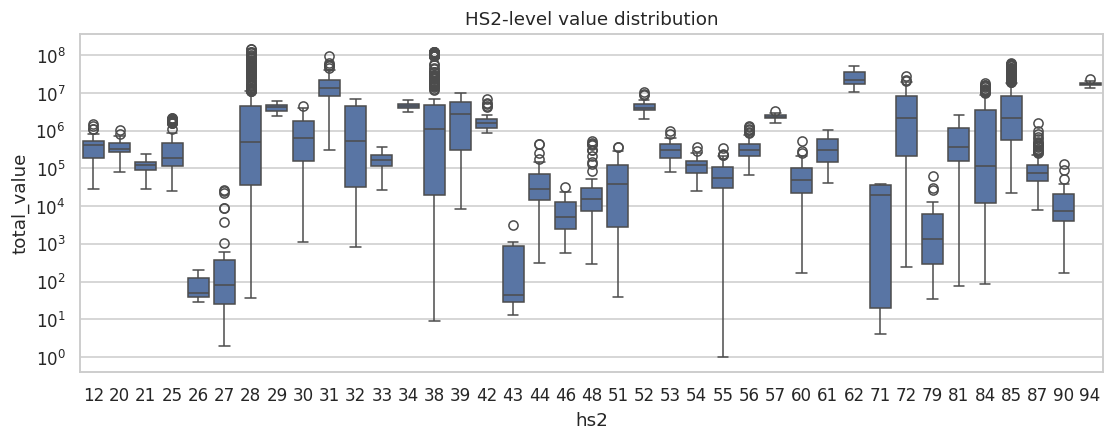

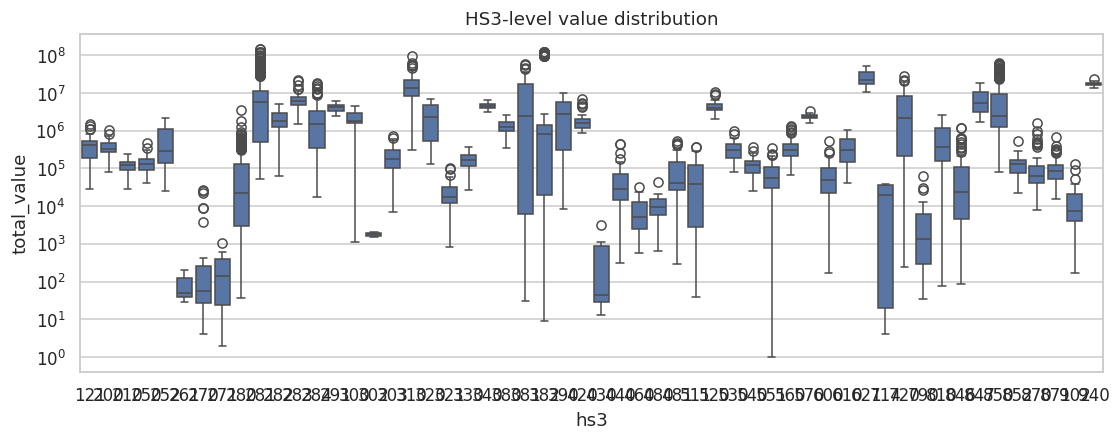

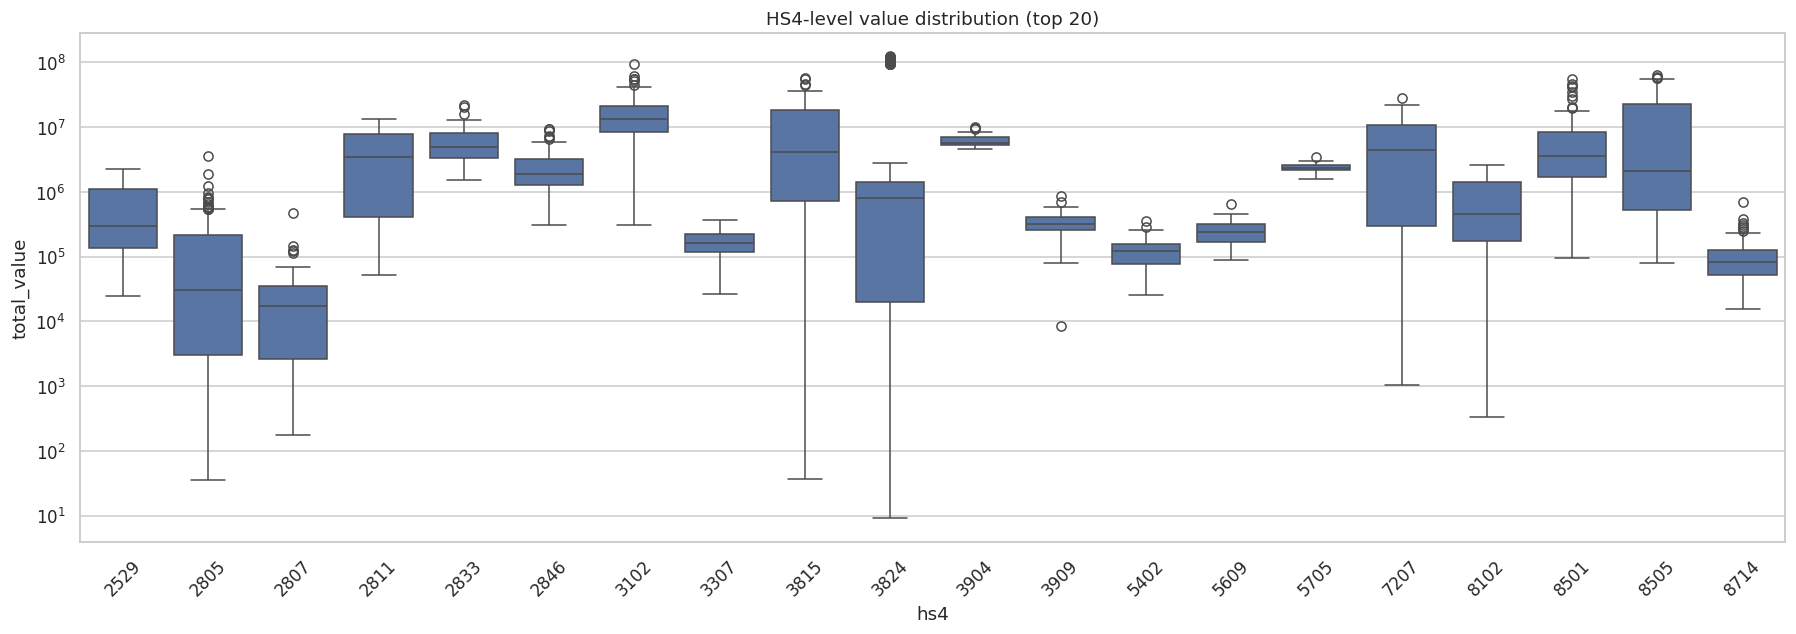

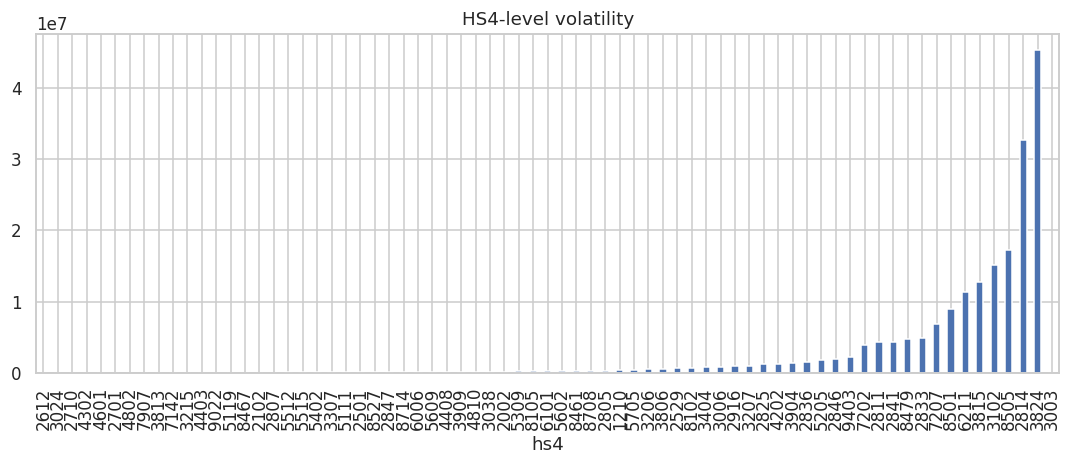

In [6]:
# ============================================================
# 4. HS2 / HS3 / HS4 Feature Power EDA
# ============================================================

# Distribution per HS level
plt.figure(figsize=(12,4))
sns.boxplot(x="hs2", y="total_value", data=df)
plt.yscale("log")
plt.title("HS2-level value distribution")
plt.show()

plt.figure(figsize=(12,4))
sns.boxplot(x="hs3", y="total_value", data=df)
plt.yscale("log")
plt.title("HS3-level value distribution")
plt.show()

plt.figure(figsize=(20,6))
hs4_top20 = df["hs4"].value_counts().head(20).index
sns.boxplot(x="hs4", y="total_value", data=df[df["hs4"].isin(hs4_top20)])
plt.yscale("log")
plt.title("HS4-level value distribution (top 20)")
plt.xticks(rotation=45)
plt.show()

# Intra-group volatility
hs4_vol = (
    df.groupby("hs4")["total_value"]
      .std()
      .sort_values()
)

plt.figure(figsize=(12,4))
hs4_vol.plot(kind="bar")
plt.title("HS4-level volatility")
plt.show()




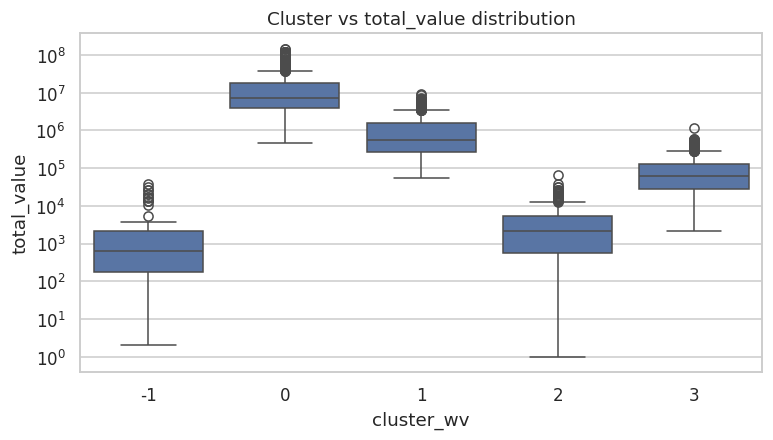

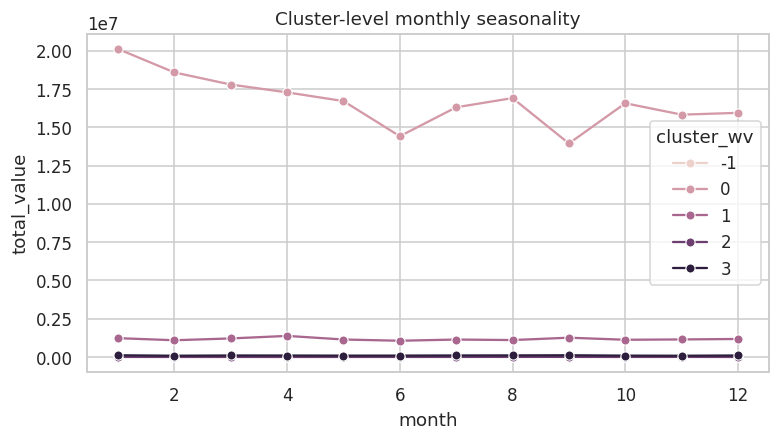

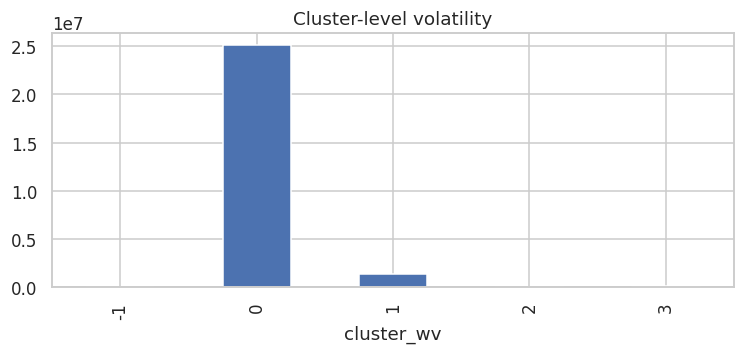

In [7]:
# ============================================================
# 5. K-means Cluster EDA (value/weight-based)
# ============================================================

# cluster vs value
plt.figure(figsize=(8,4))
sns.boxplot(x="cluster_wv", y="total_value", data=df)
plt.yscale("log")
plt.title("Cluster vs total_value distribution")
plt.show()

# cluster vs seasonality
cluster_season = (
    df.groupby(["cluster_wv", "month"])["total_value"]
      .mean()
      .reset_index()
)

plt.figure(figsize=(8,4))
sns.lineplot(data=cluster_season, x="month", y="total_value", hue="cluster_wv", marker="o")
plt.title("Cluster-level monthly seasonality")
plt.show()

# cluster volatility
cluster_vol = df.groupby("cluster_wv")["total_value"].std()

plt.figure(figsize=(8,3))
cluster_vol.plot(kind="bar")
plt.title("Cluster-level volatility")
plt.show()




In [8]:
# ============================================================
# Summary print
# ============================================================

print("\n===== Step1 EDA Summary =====")
print("1) Item-level time series analyzed (stability, rolling, volatility)")
print("2) Month-level seasonality analyzed (global + HS4-level)")
print("3) Δvalue & Δweight noise structure explored")
print("4) HS2/HS3/HS4 grouping distribution & volatility checked")
print("5) Cluster(wv) structure validated (value/weight economic grouping)")



===== Step1 EDA Summary =====
1) Item-level time series analyzed (stability, rolling, volatility)
2) Month-level seasonality analyzed (global + HS4-level)
3) Δvalue & Δweight noise structure explored
4) HS2/HS3/HS4 grouping distribution & volatility checked
5) Cluster(wv) structure validated (value/weight economic grouping)


In [17]:
# “전체 시계열은 극도로 noisy하고, 
# item-level보다는 HS4-level seasonality가 더 강하고 안정적이며, 
# cluster는 매우 불균형하고, Δvalue·Δweight는 pair에 직접 쓰기 어렵지만 ‘방향성 일관성’은 일부 그룹에서 의미가 있다.”